### 統計學習與深度學習
### Homework 3


請將IPYNB檔與IPYNB Export之HTML檔上傳至COOL作業區。回答作業時建議使用 "三明治" 答題法。也就是說，先說明要做什麼，然後列出程式碼與結果，最後說明這些結果的意義。作業自己做。嚴禁抄襲。不接受紙本繳交，不接受遲交。請以英文或中文作答。


### 第一題 [分類器、特徵建構、與Stacking]

(50%) 建構分類器時常會透過特徵選擇與Ensemble增強預測能力。本題的目的是讓大家練習這些技巧。本題使用一個中文姓名分類的資料集。這個資料集收集了10730個中文名(不含姓)，以及這些名子對應到的性別。本資料集的資料檔是**namesex_data_v2.csv**，共有三個欄位，gname, sex, fold:
* gname: 不含姓的中文名。
* sex: 1為男性，0為女性。
* fold: 為0 - 9的整數，做為後續切割資料集使用。

我們先將這個資料集讀入Numpy Array，並列印前十筆資料。

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import numpy as np

f = open('ds/namesex_data_v2.csv', 'r', encoding='utf8')
mydata = csv.DictReader(f)
sexlist = []
namelist = []
foldlist = []
for i, arow in enumerate(mydata):
    if i < 10:
        print(arow)
    sexlist.append(int(arow['sex'].strip()))
    gname = arow['gname'].strip()
    namelist.append(gname)
    foldlist.append(int(arow['fold'].strip()))

sexlist = np.asarray(sexlist)
namelist = np.asarray(namelist)
foldlist = np.asarray(foldlist)
f.close()

{'gname': '承憲', 'sex': '1', 'fold': '9'}
{'gname': '均平', 'sex': '1', 'fold': '7'}
{'gname': '思安', 'sex': '0', 'fold': '6'}
{'gname': '佑誠', 'sex': '1', 'fold': '3'}
{'gname': '乃馨', 'sex': '0', 'fold': '0'}
{'gname': '婕', 'sex': '0', 'fold': '0'}
{'gname': '冠瑜', 'sex': '0', 'fold': '1'}
{'gname': '冠學', 'sex': '1', 'fold': '0'}
{'gname': '立翰', 'sex': '1', 'fold': '2'}
{'gname': '以柔', 'sex': '0', 'fold': '6'}


接下來看一些統計數字:

In [2]:
nobs = namelist.shape[0]
print("資料筆數 = ", nobs)

資料筆數 =  10730


In [3]:
avg_sex = np.mean(sexlist)
print("男性比率", avg_sex)

男性比率 0.47940354147250697


這個資料集的男女比率還算是平均，男性佔了47.94%。

我們用了比較迂迴的方式讀檔案，Pandas其實可以直接讀csv檔。接下來做一些基本的資料分析。我們關心幾件事:
* 最常見的名子
* 共有多少個不重複的名子
* 有多少難判斷男女的名子

要回答這些問題，首先對名子加總，計算數量與男性比率，排序之後列出前20個名子:

In [3]:
import pandas as pd
name_df = pd.DataFrame({'sex': sexlist, 'name': namelist, 'fold': foldlist})
sex_tend = name_df[['name', 'sex']].groupby(["name"]).agg(['mean', 'count']).reset_index()
sex_tend.columns = ['-'.join(col).strip() for col in sex_tend.columns.values]
sex_tend = sex_tend.sort_values(['sex-count'], ascending=False)

print("最常見的20個名子:")
sex_tend.head(20)

最常見的20個名子:


,name-,sex-mean,sex-count
3738,承恩,1.000000,20
918,冠廷,1.000000,20
2506,宜蓁,0.000000,18
545,佳穎,0.000000,16
3196,彥廷,0.923077,13
913,冠宇,1.000000,13
3390,思妤,0.000000,13
1019,凱翔,1.000000,13
3769,承翰,1.000000,13
3477,怡萱,0.000000,13


由上面的列表看來，最常見的男性名子是承恩與冠廷，最常見的女性名子是宜蓁與佳穎。而這些常見的名子男性比率都非常接近0或1，表示這些名子沒有性別混淆的問題。

另外一個問題是有多少名子只出現一次:

In [5]:
single_name = np.sum(sex_tend['sex-count'] <= 1)
print("出現一次名子個數: ", single_name, "比率:", single_name / nobs)

出現一次名子個數:  7067 比率: 0.6586206896551724


由結果看來，名子在資料集中只出現一次的比率很高，有65%。也就是說，如果單純的使用訓練資料中出現的名子做為特徵，模型應該會有很差的預測能力。

#### <font color=#800000>為了處理這個問題，我們在接下來的任務中，會使用"Unigram + Full Name"的特徵表示，比如說，"芳瑜"的特徵表示為"芳"、"瑜"，以及原始的名子"芳瑜"。</font>

最後我們來看看性別混淆的名子:

In [6]:
ind1 = (sex_tend['sex-mean'] > 0.4) & (sex_tend['sex-mean'] < 0.6)
sex_amb = sex_tend[ind1]
amb_count = sex_amb['sex-count'].sum()
print("難區分性別姓名數量: ", amb_count, "比率:", amb_count/ nobs)

難區分性別姓名數量:  136 比率: 0.012674743709226468


難以區分性別的名子總數並不高，所占總體資料的比率也很低，只有1.26%，因此不用擔心這個因素會影響預測準確率。

下面來看看幾個容易混淆性別的名子:

In [7]:
sex_amb.head()

,name-,sex-mean,sex-count
6777,育瑋,0.5,4
338,以恩,0.5,4
7783,郁軒,0.5,4
2513,宜謙,0.5,4
5920,祐嘉,0.5,4


#### 實做限制
為了確保可以確實練習到重要技巧，禁用Pycaret (<https://pycaret.org/>) 這類可以自動化調教參數與Ensemble模型的工具。另外也禁止使用`sklearn.ensemble.Stacking.*`。你可以使用sklearn中Pre-processing工具函數與現成的分類器，但參數調教請自行處理。



#### 回答下面問題
#### Q1.1 (10%): 
使用One-hot Encoding建構資料變數。所有資料變數都要是Numpy Array。依照每筆資料其fold值切割為Training (fold <=6)、Validation (fold == 7)、Stacking (fold == 8)、Test (fold == 9)。每個資料集應有特徵Array(二維)以及Label Array(一維)。如前面提到的，每個名子應該要對應到全名以及單字的One-hot Encoding。比如說，"芳瑜"的特徵表示為"芳"、"瑜"，以及原始的名子"芳瑜"。建構特徵表示時應依照個特徵出現的頻率篩選。特徵在訓練資料出現兩次或以上才納入。如果一個特徵被排除，這個特徵出現時應被歸為"\_Other_Feature_"。任何名子只要有出現未被納入的特徵，則其"\_Other_Feature_"的欄位值為1。

舉例而言，假設訓練資料集中有下面三個名子: 承恩、承德、恩賜。在經過特徵頻率篩選之後，只剩下以下特徵: 承、恩。其他特徵，如承恩、承德、恩賜、德、賜皆被排除。因此最後的特徵表示為:

Input | 承 | 恩 | \_Other_Feature_ |
------|----|----|-----------------|
承恩  | 1  | 1   |  1    |
承德  | 1  | 0   |  1  |
恩賜  | 0  | 1   |  1 |

最後應產生以下Numpy Array:
* x_train: Training Features
* y_train: Training Labels
* x_valid: Validation Features
* y_valid: Validation Labels
* x_stack: Stack Features
* y_stack: Stack Labels
* x_test: Test Features
* y_test: Test Labels

請列出每個Numpy Array的Shape以資查驗。

##### construct dataframe to store name, sex, fold information

In [4]:
data = pd.DataFrame({'name': namelist, 'sex': sexlist, 'fold': foldlist})
display(data.head())
display(data.tail())
# print data shape
print("資料筆數 =", data.shape[0])

,name,sex,fold
0,承憲,1,9
1,均平,1,7
2,思安,0,6
3,佑誠,1,3
4,乃馨,0,0


,name,sex,fold
10725,嘉銘,1,3
10726,佳芸,0,8
10727,又華,0,3
10728,子晉,1,0
10729,芸靜,0,2


資料筆數 = 10730


##### use fold to split data into training, validation, stacking, and testing

In [5]:
train_set = data[data['fold'] <= 6]
validataion_set = data[data['fold'] == 7]
stacking_set = data[data['fold'] == 8]
test_set = data[data['fold'] == 9]

##### generate available feature list by counting feature frequency in training data 

In [6]:
# for every name, we first split it into characters and use set to remove duplicates
token_counting_dict = {}
feature_token_list = []
for name in train_set['name']:
    tokens = []
    if len(name) > 1:
        tokens = list(name)
    tokens.append(name)
    for token in tokens:
        if token not in token_counting_dict:
            token_counting_dict[token] = 1
        else:
            token_counting_dict[token] += 1

# we only keep tokens that appear more than 1 times
for key, value in token_counting_dict.items():
    if value > 1:
        feature_token_list.append(key)
print(f"出現多於一次的特徵字詞數量: {len(feature_token_list)}")

# feaute list should also add a feature called "_Other_Feature_"
feature_token_list.append("_Other_Feature_")

出現多於一次的特徵字詞數量: 1629


In [7]:
print(f"前 10 個特徵字詞: {list(feature_token_list)[:10]}")

前 10 個特徵字詞: ['思', '安', '佑', '誠', '乃', '馨', '婕', '冠', '瑜', '學']


##### generate one-hot encoding of each feautre for data

In [8]:
one_hot_values_for_each_name = []
for name in data['name']:
    tokens = []
    if len(name) > 1:
        tokens = list(name)
    tokens.append(name)
    one_hot_values = []
    meet_count = 0
    for feature in feature_token_list:
        if feature in tokens:
            one_hot_values.append(1)
            meet_count += 1
        else:
            one_hot_values.append(0)
    if meet_count < len(tokens):
        one_hot_values[-1] = 1
    one_hot_values_for_each_name.append(one_hot_values)
print(len(one_hot_values_for_each_name))

10730


In [9]:
# construct a dataframe for one hot values for each name
one_hot_df = pd.DataFrame(one_hot_values_for_each_name, columns=feature_token_list)
print(one_hot_df.shape)

(10730, 1630)


In [10]:
# merge one hot values with original data
data_with_features = pd.concat([data, one_hot_df], axis=1)

In [11]:
data_with_features.head()

,name,sex,fold,思,安,佑,誠,乃,馨,婕,...,冠俞,聲,珮庭,翌瑄,迦,勒,迦勒,品嘉,芷妘,_Other_Feature_
0,承憲,1,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,均平,1,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,思安,0,6,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,佑誠,1,3,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,乃馨,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [12]:
print(f"擁有不在特徵 list 內的 data count: {data_with_features['_Other_Feature_'].sum()}")

擁有不在特徵 list 內的 data count: 7948


In [13]:
##### split data into train, validation, stacking and test set, and for each set, split data into X and y
train_set = data_with_features[data_with_features['fold'] <= 6]
validation_set = data_with_features[data_with_features['fold'] == 7]
stacking_set = data_with_features[data_with_features['fold'] == 8]
test_set = data_with_features[data_with_features['fold'] == 9]

# x is feature set, y is sex
Y_train = train_set["sex"].to_numpy()
X_train = train_set.drop(columns={'sex', 'name', 'fold'}).to_numpy()

Y_validation = validation_set["sex"].to_numpy()
X_validation = validation_set.drop(columns = {'sex', 'name', 'fold'}).to_numpy()

Y_stacking = stacking_set["sex"].to_numpy()
X_stacking = stacking_set.drop(columns = {'sex', 'name', 'fold'}).to_numpy()

Y_test = test_set["sex"].to_numpy()
X_test = test_set.drop(columns = {'sex', 'name', 'fold'}).to_numpy()

# print data shape
print("資料筆數 =", data_with_features.shape[0])
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_validation shape: {X_validation.shape}, Y_validation shape: {Y_validation.shape}")
print(f"X_stacking shape: {X_stacking.shape}, Y_stacking shape: {Y_stacking.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

資料筆數 = 10730
X_train shape: (7483, 1630), Y_train shape: (7483,)
X_validation shape: (1110, 1630), Y_validation shape: (1110,)
X_stacking shape: (1073, 1630), Y_stacking shape: (1073,)
X_test shape: (1064, 1630), Y_test shape: (1064,)


#### Q1.2 (10%):
使用`sklearn.linear_model.LogisticRegression()`建構Logistic Regression分類模型。利用Training與Validation調教Regularization Coefficient $c$。Grid Search的小值為$10^{-4}$，最大值是$1,000$，總共取20個點，使用等比級數間隔。取F-1 Score最大之Regularization Coefficient，印出此數值(以下稱bestc)。將Training與Validation合併後，令Regularizaiton Coefficient為bestc，訓練最終模型，並報告Test Data的Accuracy, Precision, Recall, 與F-1 Score。另外列出係數絕對值最大的20個特徵。注意應列出未取絕對值的係數數值，方知特徵的性別傾向。討論Prediction Performance與重要特徵的合理性。


##### use np.logspace to generate regularization coefficient list

In [14]:
grids = np.logspace(-4, 3, 20)
print(f"grids length: {len(grids)}")
print("grids are listed below:")
print(grids)

grids length: 20
grids are listed below:
[1.00000000e-04 2.33572147e-04 5.45559478e-04 1.27427499e-03
 2.97635144e-03 6.95192796e-03 1.62377674e-02 3.79269019e-02
 8.85866790e-02 2.06913808e-01 4.83293024e-01 1.12883789e+00
 2.63665090e+00 6.15848211e+00 1.43844989e+01 3.35981829e+01
 7.84759970e+01 1.83298071e+02 4.28133240e+02 1.00000000e+03]


##### construct logistic regression model and use training data and validation data to tune regularization coefficient

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# use grid search to find the best C
best_score = 0
best_C = 0
for C in grids:
    lr = LogisticRegression(C= 1/C, solver='liblinear')
    lr.fit(X_train, Y_train)
    # use validation set to evaluate the model, and the score is f1 score
    score = f1_score(Y_validation, lr.predict(X_validation))
    print(f"for C = {C}, f1 score = {score}")
    if score > best_score:
        best_score = score
        best_C = C

print(f"best C = {best_C}, best f1 score = {best_score}")

for C = 0.0001, f1 score = 0.8968779564806055
for C = 0.00023357214690901214, f1 score = 0.8968779564806055
for C = 0.000545559478116852, f1 score = 0.8968779564806055
for C = 0.0012742749857031334, f1 score = 0.8968779564806055
for C = 0.002976351441631319, f1 score = 0.8960302457466919
for C = 0.0069519279617756054, f1 score = 0.8962264150943396
for C = 0.01623776739188721, f1 score = 0.8970727101038716
for C = 0.0379269019073225, f1 score = 0.8972667295004714
for C = 0.08858667904100823, f1 score = 0.8932955618508026
for C = 0.2069138081114788, f1 score = 0.8941398865784499
for C = 0.4832930238571752, f1 score = 0.8953817153628653
for C = 1.1288378916846884, f1 score = 0.8955785512699905
for C = 2.6366508987303554, f1 score = 0.8895184135977338
for C = 6.1584821106602545, f1 score = 0.8903591682419659
for C = 14.38449888287663, f1 score = 0.8811320754716981
for C = 33.59818286283781, f1 score = 0.8748824082784572
for C = 78.47599703514607, f1 score = 0.8606635071090047
for C = 183.2

##### combine training and validation data and use best coefficient to train final model

In [24]:
combine_X = np.concatenate((X_train, X_validation), axis=0)
combine_Y = np.concatenate((Y_train, Y_validation), axis=0)

final_lr = LogisticRegression(C= 1/best_C, solver='liblinear')
final_lr.fit(combine_X, combine_Y)

LogisticRegression(C=26.36650898730358, solver='liblinear')

##### report test data accuracy, precision, recall, and f1 score

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# evaluate the test set performance
print(f"test set accuracy = {accuracy_score(Y_test, final_lr.predict(X_test))}")
print(f"test set precision = {precision_score(Y_test, final_lr.predict(X_test))}")
print(f"test set recall = {recall_score(Y_test, final_lr.predict(X_test))}")
print(f"test set f1 score = {f1_score(Y_test, final_lr.predict(X_test))}")

test set accuracy = 0.8872180451127819
test set precision = 0.8590998043052838
test set recall = 0.9014373716632443
test set f1 score = 0.8797595190380761


##### comment on prediction performance
1. accuracy 約為 0.89 大於 precision，代表模型對於女性的預測可能比男性的預測更準確。
2. precision, recall, and f1 score 都有到 0.85 以上，代表這是一個不錯的模型。

##### report top 20 important features in order of absolute value and comment on their reasonability

In [26]:
top20_features = np.abs(final_lr.coef_[0]).argsort()[-20:][::-1]
print(f"top 20 features are listed below:")
for i in top20_features:
    print(f"{feature_token_list[i]}: {final_lr.coef_[0][i]}")

top 20 features are listed below:
傑: 7.1420373162815105
妤: -7.067556364556289
雯: -6.827482607034987
婷: -6.74943791566934
萱: -6.7234671602925165
潔: -6.609080599788148
美: -6.4719437843344005
凌: -6.4662938610061955
玲: -6.39609222174472
森: 6.381644682706813
婕: -6.33722703191063
靜: -6.335250075094466
薇: -6.293572763941084
蓉: -6.275507943695144
綾: -6.23110250469657
姿: -6.2033253294791395
琳: -6.104716066404483
鋒: 5.94567445151858
綺: -5.909817917994277
絃: -5.889571853813482


係數為負代表針對擁有這個特徵的名字，模型偏向預測其為女生；係數為正代表針對擁有這個特徵的名字，模型偏向預測其為男生。
而根據過往的經驗，擁有負係數的字詞確實很容易判別其為女性；而擁有正係數的字詞則很容易判別其為男性。因此，這些特徵的係數絕對值大小與其性別傾向是相符的。

#### Q1.3 (10%):
使用`sklearn.ensemble.RandomForestClassifier()`建構Random Forest分類模型。利用Training與Validation調教Number of Tress (i.e., n_estimators)。Grid Search的小值為$5$，最大值是$1,000$，總共取10個點，使用等比級數間隔。取F-1 Score最大之n_estimators，印出此數值(best_nest)。將Training與Validation合併後，令n_estimators為best_nest，訓練最終模型，並報告Test Data的Accuracy, Precision, Recall, 與F-1 Score。另外列出最重要的20個特徵。討論Prediction Performance與重要特徵的合理性。

##### use np.logspace to generate n_estimators list

In [28]:
n_estimators = np.logspace(start = np.log10(5), stop = 3, num = 10, base = 10).astype(int)
print(f"n_estimators length: {len(n_estimators)}")
print("n_estimators are listed below:")
print(n_estimators)

n_estimators length: 10
n_estimators are listed below:
[   5    9   16   29   52   94  170  308  555 1000]


##### construct random forest model and use training data and validation data to tune number of trees

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
# use grid search to find the best n_estimators
best_score = 0
best_n_estimators = 0
for n in n_estimators:
    rf = RandomForestClassifier(n_estimators = n)
    rf.fit(X_train, Y_train)
    # use validation set to evaluate the model, and the score is f1 score
    score = f1_score(Y_validation, rf.predict(X_validation))
    print(f"for n_estimators = {n}, f1 score = {score}")
    if score > best_score:
        best_score = score
        best_n_estimators = n

print(f"best n_estimators = {best_n_estimators}, best f1 score = {best_score}")


for n_estimators = 5, f1 score = 0.859047619047619
for n_estimators = 9, f1 score = 0.8601532567049809
for n_estimators = 16, f1 score = 0.8593301435406698
for n_estimators = 29, f1 score = 0.8648648648648649
for n_estimators = 52, f1 score = 0.8705656759348035
for n_estimators = 94, f1 score = 0.8698955365622033
for n_estimators = 170, f1 score = 0.8721374045801528
for n_estimators = 308, f1 score = 0.8727272727272727
for n_estimators = 555, f1 score = 0.8716475095785441
for n_estimators = 1000, f1 score = 0.8669856459330143
best n_estimators = 308, best f1 score = 0.8727272727272727


##### combine training and validation data and use best number of trees to train final model

In [30]:
final_rf = RandomForestClassifier(n_estimators = best_n_estimators)
final_rf.fit(combine_X, combine_Y)

RandomForestClassifier(n_estimators=308)

##### report test data accuracy, precision, recall, and f1 score and comment on their performance

In [31]:
# evaluate the test set performance
print(f"test set accuracy = {accuracy_score(Y_test, final_rf.predict(X_test))}")
print(f"test set precision = {precision_score(Y_test, final_rf.predict(X_test))}")
print(f"test set recall = {recall_score(Y_test, final_rf.predict(X_test))}")
print(f"test set f1 score = {f1_score(Y_test, final_rf.predict(X_test))}")

test set accuracy = 0.8468045112781954
test set precision = 0.8188976377952756
test set recall = 0.8542094455852156
test set f1 score = 0.8361809045226131


1. accuracy 比 precision 高，代表模型對於女性的預測可能比男性的預測更準確。
2. f1 score 相較於 logistic regression 的 f1 score 稍微下降，且 precision, recall 也都下降了，代表這個模型的預測能力比 logistic regression 的模型稍微差一些。

##### report top 20 important features in order of absolute value and comment on their reasonability

In [32]:
top20_features_for_rf = final_rf.feature_importances_.argsort()[-20:][::-1]
print(f"top 20 features are listed below:")
for i in top20_features_for_rf:
    print(f"{feature_token_list[i]}: {final_rf.feature_importances_[i]}")

top 20 features are listed below:
妤: 0.018895679061967183
翔: 0.015004446655767079
萱: 0.014106637029580732
柏: 0.013363128664754625
婷: 0.012980146949444651
怡: 0.009430010094688374
哲: 0.008990250669079056
雅: 0.008800676496068433
蓁: 0.008794504329507265
承: 0.00873503152372397
佳: 0.008543828503078924
芸: 0.008312775017500905
_Other_Feature_: 0.00825034636728131
晴: 0.008236809262633966
芷: 0.008225774303217602
柔: 0.008155522624151975
宜: 0.008068044086717937
庭: 0.007925928246958128
涵: 0.007877982172555009
瑄: 0.007734829217961242


Random Forest 的 importance score 代表這個特徵對於模型預測能力的重要程度。所以我們會預期 importance 越高的特徵，其在現實世界用於判別性別的能力越強。而這些特徵的 importance score 確實與其在現實世界用於判別性別的能力相符，也就是很容易根據 score 高的特徵來區分男女。

#### Q1.4 (10%):
使用`sklearn.ensemble.GradientBoostingClassifier()`建構Gradient Boosting Decision Tree (GBDT)分類模型。利用Training與Validation調教learning_rate與n_estimators。考慮以下Learning Rate: 0.1, 0.5, 1。每一個Learning Rate設n_estimator為1,500並估計一個GBDT分類器，計算1,500個Stages下Validation F-1 Score值，繪圖，並找出讓F-1 Score最大的Stage與F-1 Score最大值。對所有Learning Rate重複同樣程序，找出最佳的Learning Rate (稱best_lr) 與其對應的Number of Stages(best_nstg)。將Training與Validation合併後，令learning_rate為best_lr, n_estimators為best_nstg，訓練最終模型，並報告Test Data的Accuracy, Precision, Recall, 與F-1 Score。另外列出最重要的20個特徵。討論Prediction Performance與重要特徵的合理性。

##### construct gradient boosting model and use training data and validation data to tune learning rate and number of trees

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

learning_rate = [0.1, 0.5, 1]

lr_f1_list_dict = {
    0.1: [],
    0.5: [],
    1: []
}
# for every learning rate, we set n_estimators = 1500 

# use grid search to find the best learning rate
global_best_score = 0
global_best_stage = 0
global_best_learning_rate = 0
for lr in learning_rate:
    best_score_for_current_lr = 0
    best_stage_for_current_lr = 0
    gb = GradientBoostingClassifier(learning_rate = lr, n_estimators = 1500)
    gb.fit(X_train, Y_train)
    
    # find best stage for each learning rate
    for index, y_valid_pred in enumerate(gb.staged_predict(X_validation)):
        score = f1_score(Y_validation, y_valid_pred)
        lr_f1_list_dict[lr].append(score)
        if score > best_score_for_current_lr:
            best_score_for_current_lr = score
            best_stage_for_current_lr = index
        if score > global_best_score:
            global_best_score = score
            global_best_learning_rate = lr
            global_best_stage = best_stage_for_current_lr
    print(f"for learning rate = {lr}, best stage = {best_stage_for_current_lr}, best f1 score = {best_score_for_current_lr}")

print(f"global best learning rate = {global_best_learning_rate}, global best stage = {global_best_stage}, global best f1 score = {global_best_score}")

for learning rate = 0.1, best stage = 868, best f1 score = 0.904717853839038
for learning rate = 0.5, best stage = 231, best f1 score = 0.907563025210084
for learning rate = 1, best stage = 134, best f1 score = 0.896551724137931
global best learning rate = 0.5, global best stage = 231, global best f1 score = 0.907563025210084


##### draw the f1-score curve of validation data for each learning rate

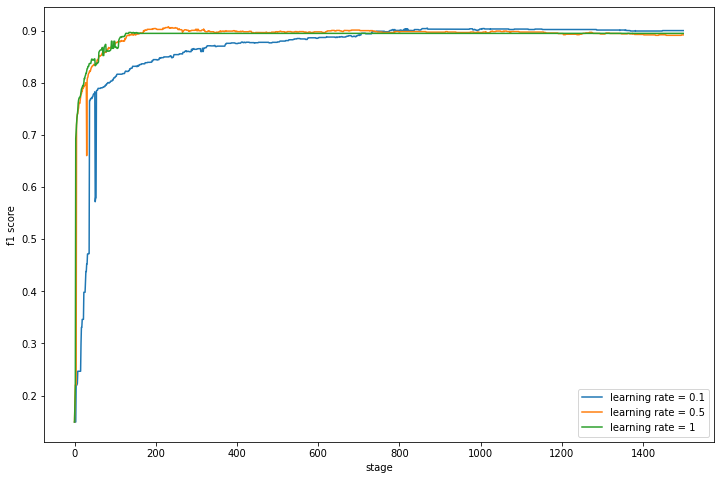

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(lr_f1_list_dict[0.1], label = "learning rate = 0.1")
plt.plot(lr_f1_list_dict[0.5], label = "learning rate = 0.5")
plt.plot(lr_f1_list_dict[1], label = "learning rate = 1")
plt.legend()
plt.xlabel("stage")
plt.ylabel("f1 score")
plt.show()

best learning rate is 0.5, best stage is 231, and the best f1-score is 0.907563025210084

##### combine training and validation data and use best learning rate and number of trees to train final model. Show the performance of test data and comment on it.

In [21]:
# combine train and validation set and train the model with the best learning rate and stage
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

final_gb = GradientBoostingClassifier(learning_rate = global_best_learning_rate, n_estimators = global_best_stage)
final_gb.fit(combine_X, combine_Y)

# evaluate the test set performance
print(f"test set accuracy = {accuracy_score(Y_test, final_gb.predict(X_test))}")
print(f"test set precision = {precision_score(Y_test, final_gb.predict(X_test))}")
print(f"test set recall = {recall_score(Y_test, final_gb.predict(X_test))}")
print(f"test set f1 score = {f1_score(Y_test, final_gb.predict(X_test))}")

test set accuracy = 0.8768796992481203
test set precision = 0.8345864661654135
test set recall = 0.9117043121149897
test set f1 score = 0.8714425907752698


1. accuracy 比 precision 高，代表模型對於女性的預測可能比男性的預測更準確。
2. f1 score 與 logistic regression 的 f1 score 幾乎相同，且 precision, recall 也都非常接近，代表這個模型的預測能力與 logistic regression 的模型相當，是個不錯的模型。

##### report top 20 important features in order of absolute value and comment on their reasonability

In [22]:
# find the top 20 features for gradient boosting model
top20_features_for_gb = final_gb.feature_importances_.argsort()[-20:][::-1]
print(f"top 20 features are listed below:")
for i in top20_features_for_gb:
    print(f"{feature_token_list[i]}: {final_gb.feature_importances_[i]}")
    

top 20 features are listed below:
妤: 0.02980714761736388
翔: 0.021888350121447613
萱: 0.02005030135776806
柏: 0.01980237959735347
婷: 0.01904786130561412
哲: 0.013056596270472093
承: 0.012688309149128914
蓁: 0.012516104907777397
怡: 0.01190112550020197
晴: 0.011745650094158675
柔: 0.011369850093555437
雅: 0.011095470265687291
涵: 0.010840828618756543
宜: 0.0108368716884609
佳: 0.010830077040059578
芷: 0.010693016530669085
芸: 0.01063903477484346
慈: 0.010370633278762975
瑄: 0.009869143158338893
婕: 0.00971326876559622


與 Random Forest 概念類似，Gradient Boosting 的 importance score 也反映這個特徵對於模型預測能力的重要程度。所以我們會預期 importance 越高的特徵，其在現實世界用於判別性別的能力越強。而透過上方條列的這些特徵，其 importance score 確實與其在現實世界用於判別性別的能力相符，也就是很容易根據 score 高的特徵來區分男女。

#### Q1.5 (10%):
取用前面所建構的Logistic Regression, Random Forest, 與Gradient Boosting Decision Tree, 組合(Stacking)成一個新的分類器。我們使用Logistic Regression without Penalty建構這個Stacking分類器。訓練資料為Stacking資料集。各分類器輸入的特徵為男生預測機率(注意: 不是分類結果)。列出Stacking分類器的係數，討論係數的意義，並計算這個Stacking分類器在Test資料集的預測能力。

##### construct a stacking model using logistic regression without penalty. Show the coefficients of logistic regression stacking classifier and comment on it.

In [40]:
# use previous learned models to construct a stacking model, and do not use ensemble.StackingClassifier
# input contains three columns, each column is the output of the class 1 probability of  previous learned models (lr, rf, gb)
# output is the class 1 probability of the stacking model

stacking_input = np.concatenate((
    final_lr.predict_proba(X_stacking)[:, 1].reshape(-1, 1), 
    final_rf.predict_proba(X_stacking)[:, 1].reshape(-1, 1), 
    final_gb.predict_proba(X_stacking)[:, 1].reshape(-1, 1)), 
    axis = 1
)
stack_classifier = LogisticRegression(penalty = "none")
stack_classifier.fit(stacking_input, Y_stacking)

# coefficient of the logistic regression model
print(f"coefficient of the logistic regression model = {stack_classifier.coef_}")

coefficient of the logistic regression model = [[ 2.55639626 -0.07958292  5.56376362]]


從 stacking classifier 的係數可以看出， gradient boosting 的係數最大，代表 gradient boosting 預測能力對於 output 的影響最大。而 random forest 的係數最小，代表 random forest 預測能力對於 output 的影響最小。

In [41]:
# evaluate the test set performance
x_prob_test = np.concatenate((
    final_lr.predict_proba(X_test)[:, 1].reshape(-1, 1), 
    final_rf.predict_proba(X_test)[:, 1].reshape(-1, 1), 
    final_gb.predict_proba(X_test)[:, 1].reshape(-1, 1)), 
    axis = 1
)
print(f"test set accuracy = {accuracy_score(Y_test, stack_classifier.predict(x_prob_test))}")
print(f"test set precision = {precision_score(Y_test, stack_classifier.predict(x_prob_test))}")
print(f"test set recall = {recall_score(Y_test, stack_classifier.predict(x_prob_test))}")
print(f"test set f1 score = {f1_score(Y_test, stack_classifier.predict(x_prob_test))}")


test set accuracy = 0.8862781954887218
test set precision = 0.8546511627906976
test set recall = 0.9055441478439425
test set f1 score = 0.8793619142572283


可以看到 stacking classifier 的 performance 與 logistic regression 的 accuracy 相當，而在 recall 上則是比 logistic regression 高，代表 stacking classifier 的表現是不錯的

## 第二題 [Data Visualization via Dimensionality Reduction]

Data visualization is a useful technique that can help us understand the characteristics of a dataset. We are going to practice this skill using the  University Offer of Admission Dataset (UDOAD).  

#### Dataset: University Department Offer of Admission Dataset (UDOAD; 大學推薦甄選資料集)

Many high school students get admitted to universities through an application and screening process that requires each university department to offer admission to applicants first before students can choose where they want to go. Suppose we think of applicants as the customers of an academic department. In that case, the duplications of offered applicants from different departments can be used to understand the competitive relationships between academic departments. We are going to visualize this competition relationship using UDOAD. 

UDOAD was collected through a popular online offer searching service (https://freshman.tw/; site no longer operational) for the 2017 academic year. We collected the offers received by each applicant as well as the basic information for academic departments. This dataset contains two files
* student_admission106.csv: the offers received by each student applicant. 
* univ_name106short1.csv: the basic information, such as the name and field of academic departments. 

Below is the first few records of these two files:

In [133]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

stu_adm = pd.read_csv('ds/student_admission106.csv', encoding="utf-8", dtype=str)
uname = pd.read_csv('ds/univ_name106short1.csv', encoding="utf-8", dtype=str)

all_depid = stu_adm['department_id'].unique()
all_stuid = stu_adm['student_id'].unique()

ndepid = all_depid.shape[0]
nstuid = all_stuid.shape[0]
print("There are %d students and %d departments in total." % (nstuid, ndepid))

print("offers received by students:")
stu_adm.head(10)

There are 60461 students and 1976 departments in total.
offers received by students:


,school_id,department_id,student_id,student_name,state,location1,location2
0,001,001012,10246842,黃士玹,正1,南部,台南考區
1,001,001012,10042237,黃冠婷,正2,北部,台北考區
2,001,001012,10008031,鍾大方,正3,北部,台北考區
3,001,001012,10201525,曾信豪,正4,中部,彰化考區
4,001,001012,10014615,陳品儒,正5,北部,台北考區
5,001,001012,10294018,侯思筠,正6,東部,宜蘭考區
6,001,001012,10022810,吳悅慈,正7,北部,台北考區
7,001,001012,10236223,陳俞潔,正8,南部,台南考區
8,001,001012,10025909,蕭宇廷,正9,北部,台北考區
9,001,001012,10123708,吳岱軒,正10,北部,中壢考區


The department_id can uniquely identify an academic department. We do not care about the ranking of admission here, and you should ignore the "state" column. We only care about the "co-application" relations in this dataset. You should use student_id to identify a student applicant uniquely. 

In [134]:
print("academic department basic information:")
uname.head(10)

academic department basic information:


,year,school_id,department_id,school_name,department_name,category_id,category_name,school_name_abbr,department_name_abbr
0,106,006,006042,國立政治大學,教育學系,1,教育,政大,教育
1,106,006,006052,國立政治大學,教育學系(公費生),1,教育,政大,教育(公)
2,106,006,006062,國立政治大學,教育學系(原住民公費生),1,教育,政大,教育(原住民)
3,106,006,006022,國立政治大學,歷史學系,2,藝術及人文,政大,歷史
4,106,006,006152,國立政治大學,民族學系,2,藝術及人文,政大,民族學
5,106,006,006032,國立政治大學,哲學系,2,藝術及人文,政大,哲學
6,106,006,006262,國立政治大學,英國語文學系,2,藝術及人文,政大,英國語文
7,106,006,006292,國立政治大學,日本語文學系,2,藝術及人文,政大,日本語文
8,106,006,006272,國立政治大學,阿拉伯語文學系,2,藝術及人文,政大,阿拉伯語文
9,106,006,006302,國立政治大學,韓國語文學系,2,藝術及人文,政大,韓國語文


You can use this dataset to identify the name of a department_id. The school_name and department_name contain the "full name" of an academic department. To facilitate visualization, we also provide "shorter names" in school_name_abbr and department_name_abbr. The category_name is the field of an academic department. This field is essential in our visualization exercise since you should color each data point according to its category_name. 

#### Implementation Restrictions
You are allowed to use any Python libraries in your solution. 

### Data Preparation
Our focus is on the relationships between departments. To do this, we need to convert the raw data into a "matrix" representation. Each row represents an academic department, and each column represents a student applicant. The cell's value is one if a student applied for admission to the corresponding academic department, and 0 otherwise. 

To avoid potential numerical problems, we only include an academic department if it received ten or more applications. Moreover, we only include a student applicant if he or she applied for more than one academic department. 

Note that the two conditions should be satisfied "as is" in after preprocessing. For example, suppose a student applied for two departments in the original dataset, and one of the departments was removed. In that case, this student should be removed because the student only applied for one department in the processed dataset. 



In [135]:
%matplotlib inline
import numpy as np
import pandas as pd

stu_adm = pd.read_csv('ds/student_admission106.csv', encoding="utf-8", dtype=str)
uname = pd.read_csv('ds/univ_name106short1.csv', encoding="utf-8", dtype=str)

all_depid = stu_adm['department_id'].unique()
all_stuid = stu_adm['student_id'].unique()

ndepid = all_depid.shape[0]
nstuid = all_stuid.shape[0]
print("In raw data, there are %d students and %d departments in total." % (nstuid, ndepid))

#construct the department-student matrix (i.e. array). 
dep_stu = np.zeros((ndepid, nstuid))
rowname = all_depid.copy()

depid_seq_map = dict()
for i in range(ndepid):
    depid_seq_map[all_depid[i]] = i

stuid_seq_map = dict()
for i in range(nstuid):
    stuid_seq_map[all_stuid[i]] = i

for cindex, row in stu_adm.iterrows():
    #print(cindex, row)
    dep_seq = depid_seq_map[row['department_id']]
    stu_seq = stuid_seq_map[row['student_id']]
    #print(dep_seq, stu_seq)
    dep_stu[dep_seq, stu_seq] = 1

#Remove very small departments.
min_stu_per_dep = 10
min_apply_dep_per_stu = 2

#remove small departments and single-application students. 
dep_apply_sum = np.sum(dep_stu, axis = 1)
keeprow = dep_apply_sum >= min_stu_per_dep
rowname = rowname[keeprow]
dep_stu2 = dep_stu[keeprow,:]
stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

#another run of filtering
dep_apply_sum = np.sum(dep_stu2, axis = 1)
dep_stu2 = dep_stu2[dep_apply_sum >= min_stu_per_dep,:]
rowname = rowname[dep_apply_sum >= min_stu_per_dep]
stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

#third run of filtering
dep_apply_sum = np.sum(dep_stu2, axis = 1)
dep_stu2 = dep_stu2[dep_apply_sum >= min_stu_per_dep,:]
rowname = rowname[dep_apply_sum >= min_stu_per_dep]

stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

#check to make sure the two conditions are satisfied. 
dep_apply_sum = np.sum(dep_stu2, axis = 1)
print("Number of department too small:", np.sum(dep_apply_sum < min_stu_per_dep))
stu_apply_sum = np.sum(dep_stu2, axis = 0)
print("Number of students applying only one department:", np.sum(stu_apply_sum <min_apply_dep_per_stu))

#now both conditions are satisfied.

In raw data, there are 60461 students and 1976 departments in total.
Number of department too small: 0
Number of students applying only one department: 0


Report the number of academic departments and student applicants in the processed dataset: 

In [136]:
num_dep, num_stu = dep_stu2.shape
print("In final dataset, there are", num_dep, "academic departments and", num_stu, "student applicants.")

In final dataset, there are 1917 academic departments and 47386 student applicants.


Report the top ten departments that received the most applications and the number of applications they received:

In [137]:
uname['depname'] = uname.school_name_abbr + uname.department_name_abbr
uname2 = uname[['department_id', 'depname', 'category_name']].copy()
#this is for later use, to color data points. 
category_id, category_levels = pd.factorize(uname2.category_name)
#uname2['category_id'] = category_id / np.max(category_id)
uname2['category_id'] = category_id

#create a data frame for column name
colname_df = pd.DataFrame({'department_id': rowname})
colname_df = colname_df.merge(uname2, how = "left", on="department_id")

In [138]:
topdepid = np.argsort(dep_apply_sum)[::-1]
topn = 10
topdep = pd.DataFrame({'department_id': rowname[topdepid[0:topn]], 
                       'department_name': colname_df.depname.values[topdepid[0:topn]],
                       'num_applicant': dep_apply_sum[topdepid[0:topn]]
                       }) 
topdep

,department_id,department_name,num_applicant
0,008122,中原機械工程學,386.0
1,012052,中醫藥學,376.0
2,046032,銘傳會計（臺北）,367.0
3,004382,成大電機,357.0
4,005192,東吳企業管理,353.0
5,008112,中原土木,353.0
6,005182,東吳會計,351.0
7,015342,逢甲財金,340.0
8,045012,義守電機,339.0
9,046162,銘傳應用英語（桃園）,329.0


### Answer the following questions
Visualize academic departments in the following questions. In all plots, you should color data points according to the academic department's category. Moreover, you should provide a legend or a picture that illustrates the mapping between colors and category names. Visualize the data using two-dimensional plots. Note that it is your responsibility to study the documentation of your choice libraries and make sure that the results are reasonable. 
* Q2.1 (10%): Visualize academic departments using the first eight principal components. Use your judgment to select multiple pairs of principal components to visualize. Discuss the visual patterns concerning department categories. 
* Q2.2 (10%): Visualize academic departments using multiple dimensional scaling. Consider both the metric and non-metric settings. Discuss the result. 
* Q2.3 (10%): Visualize academic departments using Locally Linear Embedding. Consider three variations: (1) Use 20 neighbors to construct the weight matrix; (2) Use 40 neighbors to construct the weight matrix; (3) Perform PCA transformation first, and use the first 100 principal components as the input to LLE (with 20 neighbors). Discuss the result. 
* Q2.4 (10%): Visualize academic departments using Kernel PCA. You should at least consider the RBF and Cosine kernel. It is your responsibility to select reasonably good kernel parameters. Discuss the result. 
* Q2.5 (10%): Visualize academic departments using t-SNE. You should consider at least the Euclidian, Cosine, and Jaccard metric. Set numpy random seed so that your results can be repeated. Discuss the result. 
* Q2.6 (10%) Select the most promising visualization method in the previous question and refine the result. You should color points by department category. Label each data point with its name so that we can quickly identify a data point on the picture. Moreover, you should try to reduce the problem caused by overlapping points and labels. Output an image that is large enough so that a user can easily identify a department and its neighbors. Jupyter Lab has limitations on the largest picture size. To overcome this problem, output the picture to a separate file and submit the file for grading. Your score depends on how useful, readable, and visually pleasing of your visualization results. 

---
### Solution
---

Add cells below and answer the questions below.

#### Data Preparation

1. We first need to define the category_id-to-category_name mapping

In [139]:
category_id_list = colname_df['category_id'].unique().tolist()

# for each category_id, find its corresponding category_name
category_map = dict()
for i in category_id_list:
    category_map[i] = uname2[uname2['category_id'] == i]['category_name'].unique()[0]

# print category map
for i in category_map:
    print(i, category_map[i])

1 藝術及人文
2 社會科學、新聞學及圖書資訊
4 自然科學、數學及統計
7 醫藥衛生及社會福利
6 工程、製造及營建
9 農業、林業、漁業及獸醫
3 商業、管理及法律
5 資訊通訊科技
0 教育
8 其他
10 服務


2. We then need to define the category_id-to-color mapping

In [140]:
color_map = dict()
# generate 11 colors
color_list = ['red', 'blue', 'green', 'yellow', 'black', 'purple', 'orange', 'pink', 'brown', 'gray', 'cyan']
for i in range(len(color_list)):
    color_map[i] = color_list[i]

# print color map
for i in color_map:
    print(f"category id: {i}, category name: {category_map[i]}, color: {color_map[i]}")

category id: 0, category name: 教育, color: red
category id: 1, category name: 藝術及人文, color: blue
category id: 2, category name: 社會科學、新聞學及圖書資訊, color: green
category id: 3, category name: 商業、管理及法律, color: yellow
category id: 4, category name: 自然科學、數學及統計, color: black
category id: 5, category name: 資訊通訊科技, color: purple
category id: 6, category name: 工程、製造及營建, color: orange
category id: 7, category name: 醫藥衛生及社會福利, color: pink
category id: 8, category name: 其他, color: brown
category id: 9, category name: 農業、林業、漁業及獸醫, color: gray
category id: 10, category name: 服務, color: cyan


#### Q2.1

In [141]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [142]:
# use PCA to reduce dimensionality
pca = PCA(n_components=8)
pca.fit(dep_stu2)
dep_stu_pca = pca.transform(dep_stu2)

In [143]:
dep_stu_pca.shape

(1917, 8)

接下來將使用 PCA 降維後的前八個主成分 (pc1, pc2, ..., pc8) 來視覺化資料
而我們會畫四張圖，分別是 (pc1, pc2), (pc3, pc4), (pc5, pc6), (pc7, pc8) 的 scatter plot 以觀察 category 的分布

In [144]:
# for all departments, construct its corresponding color list
all_dep_colors = []
for index, row in colname_df.iterrows():
    all_dep_colors.append(color_map[row['category_id']])

In [152]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.figsize'] = [8, 6]
def plot_pca_scatter(p1, p2, color_map, x_label, y_label):
    plt.scatter(p1, p2, c=all_dep_colors, s=60)
    markers = [plt.Line2D([0,0], [0,0], color=color, marker='o', linestyle='') for color in color_map.values()]
    plt.legend(markers, color_map.keys(), numpoints=1)
    # show legend with color_map
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()


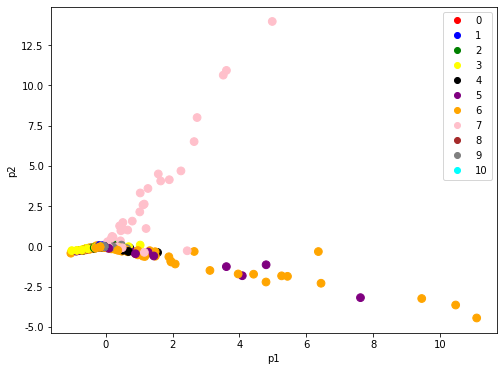

In [153]:
p1 = dep_stu_pca[:, 0]
p2 = dep_stu_pca[:, 1]
plot_pca_scatter(p1, p2, color_map, 'p1', 'p2')

color_id 為 7 的 category_name 為 "其他"，而可以看出其在 p2 上的分布很分散，而在 p1 上則較為集中，表示 p1 在 "其他" 的分類能力相較 p2 更好

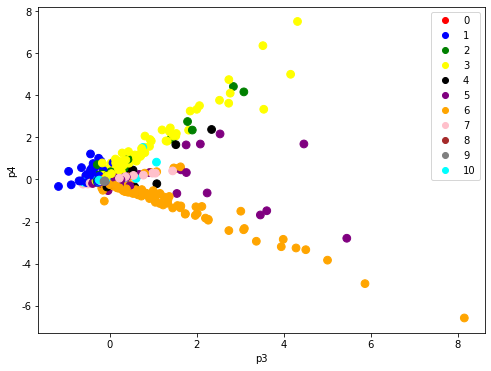

In [154]:
p3 = dep_stu_pca[:, 2]
p4 = dep_stu_pca[:, 3]
plot_pca_scatter(p3, p4, color_map, 'p3', 'p4')

p3, p4 所畫出來的圖形在 category_id 為 1 (藝術及人文) 的分布較為集中，而在其他 category 的分布則較為分散，表示 p3, p4 在 "藝術及人文" 的分類能力可能較好

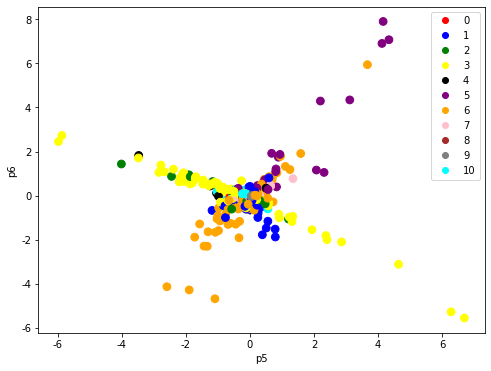

In [155]:
p5 = dep_stu_pca[:, 4]
p6 = dep_stu_pca[:, 5]
plot_pca_scatter(p5, p6, color_map, 'p5', 'p6')

p5, p6 看不出來有明顯的分布

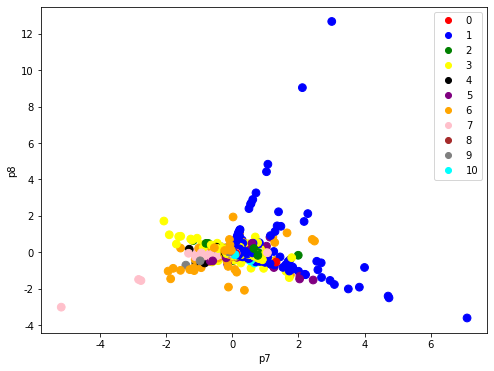

In [156]:
p7 = dep_stu_pca[:, 6]
p8 = dep_stu_pca[:, 7]
plot_pca_scatter(p7, p8, color_map, 'p7', 'p8')

p7, p8 中 category_id 為 1 的分類 (藝術及人文) 在兩軸上都非常分散，代表 p7, p8 可能不是很適合用來分類 "藝術及人文"

結論：
透過 PCA 我們可以大幅降維，而且在不同主成分的分布上都略有不同，讓我們對資料的長相及特性更有了解。但其可能不是最適合的方法，因為還是有許多分類不清的地方，包含 p7, p8 中間的分類非常密布且雜亂等。

#### Q2.2

##### Metric MDS

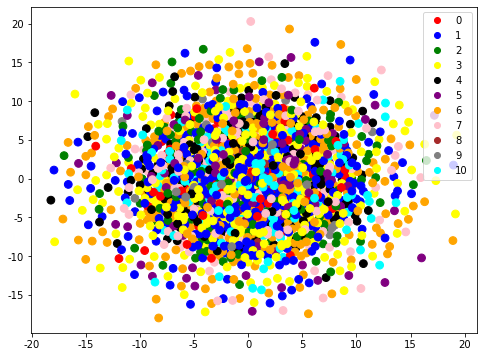

In [159]:
# use MDS to reduce dimensionality and plot scatter plot
from sklearn.manifold import MDS
mds = MDS(n_components=2, metric=True)
dep_stu_mds = mds.fit_transform(dep_stu2)

plt.scatter(dep_stu_mds[:, 0], dep_stu_mds[:, 1], c=all_dep_colors, s=60)
markers = [plt.Line2D([0,0], [0,0], color=color, marker='o', linestyle='') for color in color_map.values()]
plt.legend(markers, color_map.keys(), numpoints=1)
plt.show()

##### Non-Metric MDS

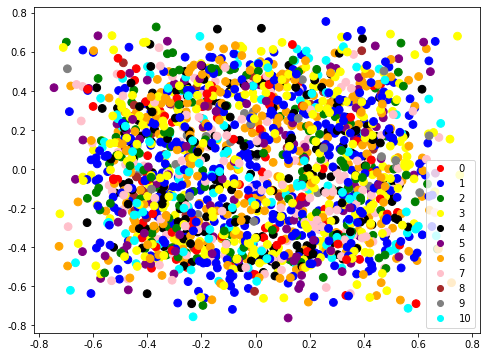

In [160]:
non_metric_mds = MDS(n_components=2, metric=False)
dep_stu_non_metric_mds = non_metric_mds.fit_transform(dep_stu2)

plt.scatter(dep_stu_non_metric_mds[:, 0], dep_stu_non_metric_mds[:, 1], c=all_dep_colors, s=60)
markers = [plt.Line2D([0,0], [0,0], color=color, marker='o', linestyle='') for color in color_map.values()]
plt.legend(markers, color_map.keys(), numpoints=1)
plt.show()

Conclusion: 由上兩圖得知 MDS 降成兩維後的分類效果非常不佳，無法看出任何同 category 之間較密集的分布，因此在這個 dataset 中 MDS 並不適合用來降維

#### Q2.3

##### LLE with 20 neighbors

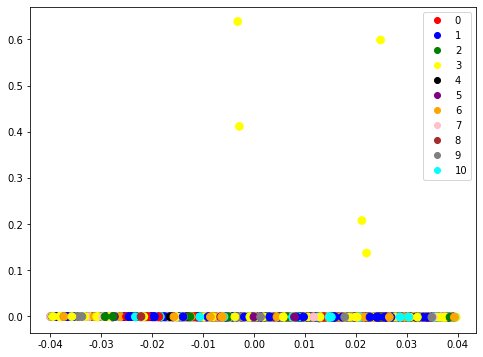

In [161]:
# using LLE with 20 neighbors to reduce dimensionality
from sklearn.manifold import LocallyLinearEmbedding
lle_20 = LocallyLinearEmbedding(n_components=2, n_neighbors=20)

dep_stu_lle_20 = lle_20.fit_transform(dep_stu2)

# plot scatter plot
plt.scatter(dep_stu_lle_20[:, 0], dep_stu_lle_20[:, 1], c=all_dep_colors, s=60)
markers = [plt.Line2D([0,0], [0,0], color=color, marker='o', linestyle='') for color in color_map.values()]
plt.legend(markers, color_map.keys(), numpoints=1)
plt.show()


從上圖看出，LLE 在降成兩維後的分類效果並不好，很多 data points 都黏在一起，無法看出任一 category 間較密集的分布